Alumno: Milton Aldair Martínez Acosta  

Matrícula: 1870354

Estadística Aplicada

Grupo: 051

# pronóstico de series de tiempo

En esta notebook vamos a realizar el pronóstico de una serie de tiempo
1. Descargaremos los datos
2. Graficaremos la series para darnos una idea de su comportamiento
3. realizaremos una prueba de raíz unitaria para comprobrar si la serie es estacionaria
4. Diferenciaremos la serie en caso de que no sea estacionaria
5. Realizamos la prueba a la serie diferenciada para ver si es estacionaria
6. Graficaremos la serie estacionaria
7. realizaremos su ACF y PACF para tratar de identificar que tipo de proceso es MA(q), AR(P), ARMA(p,q), etc
8. Estimamos distintos modelos
9. Elegimos el modelo
10. Realizamos el pronóstico 

In [2]:
# como siempre comenzamos importando las librerias
import numpy as np
import pandas as pd 
import yfinance as yf
import scipy.stats as stats
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima.model import ARIMA

%matplotlib inline

In [10]:
#fijamos tamaño de graficas
plt.rcParams['figure.figsize'] = [10, 7.5]

## 1. Importamos los datos desde la api de yahoo finance

en mi caso yo voy a utilizar las acciones de PEPSICO y voy a utilizar la información de los 21 meses hasta el día viernes, que es cuando estuvo abierta la bolsa

In [4]:
#recuerda instalar yahoo finance con-> pip install yfinance
pep = yf.download('PEP', 
                       start='2020-06-11', 
                       end='2022-03-12',
                       progress=False)

In [5]:
#vemos los ultimos 10 datos
pep.tail(10)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-02-28,164.039993,165.210007,161.410004,163.740005,162.670105,7673500
2022-03-01,163.070007,164.399994,161.300003,162.270004,161.209702,5107900
2022-03-02,162.979996,165.820007,162.490005,164.520004,163.445007,5452100
2022-03-03,163.970001,165.190002,162.800003,163.270004,163.270004,5352200
2022-03-04,162.000000,166.500000,160.919998,165.750000,165.750000,6340300
2022-03-07,164.070007,165.149994,162.130005,162.449997,162.449997,6319500
2022-03-08,162.380005,163.970001,157.690002,157.869995,157.869995,6163700
2022-03-09,159.809998,160.059998,156.399994,157.399994,157.399994,5764900
2022-03-10,155.789993,156.250000,153.369995,154.509995,154.509995,6103700


In [6]:
##Voy renombar columna 'Adj Close' por adj_close 
pep.rename(columns = {'Adj Close':'adj_close'}, inplace=True)

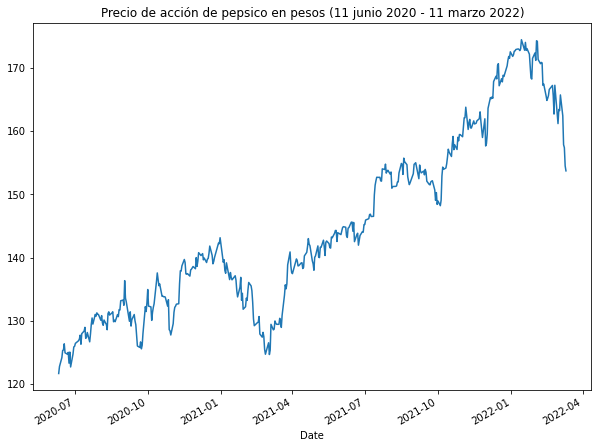

In [11]:
# vamos a graficar
pep.adj_close.plot()
plt.title('Precio de acción de pepsico en pesos (11 marzo 2019 - 11 marzo 2022)')
plt.show()

In [12]:
#hacemos la prueba de dickey fuller aumentada ADF
adf = adfuller(pep['adj_close'])

#presentamos el p-value
print('p-value: %f' % adf[1])



p-value: 0.534653


Recuerda que $H_0$: serie no estacionaria

In [13]:
if adf[1] < 0.05:
    
    print(f'con un un p-value={adf[1].round(3)}\n Se rechaza hipótesis nula, serie estacionaria') 
    
else:
    
    print(f'con un un p-value = {adf[1].round(3)}\n NO se rechaza hipótesis nula, serie no estacionaria') 


con un un p-value = 0.535
 NO se rechaza hipótesis nula, serie no estacionaria


para hacer la serie estacionaria, usaremos lafunción shift de pandas 

y guardaremos la serie diferenciada en un objeto aparte

In [14]:
pep_diff = pep['adj_close'] - pep['adj_close'].shift()

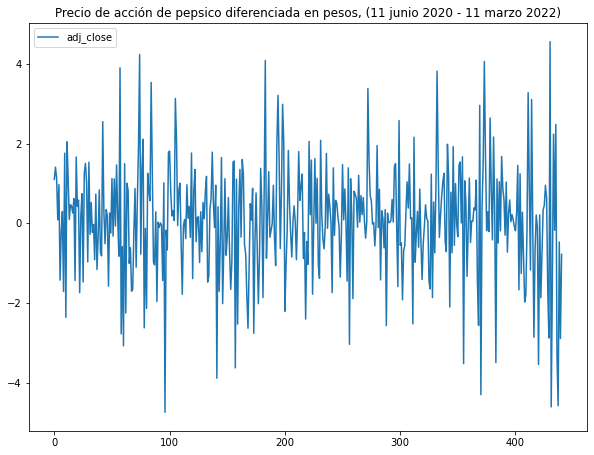

In [27]:
#graficamos el tipo de cambio diferenciado
pep_diff.plot()
plt.title('Precio de acción de pepsico diferenciada en pesos, (11 junio 2020 - 11 marzo 2022)')
plt.show()

In [16]:
#eliminamos los Nan
pep_diff = pep_diff.dropna()

In [17]:
## como la serie tiene saltos (los fines de semana los mercados no abren)
## removeremos la fecha
pep_diff = pep_diff.reset_index()

### eliminamos columna fecha
pep_diff = pep_diff.drop(['Date'], axis=1)

In [29]:
pep_diff

,adj_close
0,1.103851
1,1.408363
2,1.132408
3,0.085602
4,0.970642
...,...
436,-3.300003
437,-4.580002
438,-0.470001
439,-2.889999


volvemos a realizar la prueba de raíz unitaria ADF

In [20]:
#hacemos la prueba de dickey fuller aumentada ADF
adf1 = adfuller(pep_diff)

#presentamos el p-value
print('p-value: %f' % adf1[1])

p-value: 0.000000


In [21]:
adf1 = adfuller(pep_diff)
if adf1[1] < 0.05:
    
    print(f'con un un p-value={adf1[1]}\n Se rechaza hipótesis nula, serie estacionaria') 
    
else:
    
    print(f'con un un p-value = {adf1[1]}\n NO se rechaza hipótesis nula, serie no estacionaria') 


con un un p-value=0.0
 Se rechaza hipótesis nula, serie estacionaria


Ahora que la serie ya es estacionaria, podemos hacer pronósticos con ella
por tanto debemos identificar que tipo de proceso es


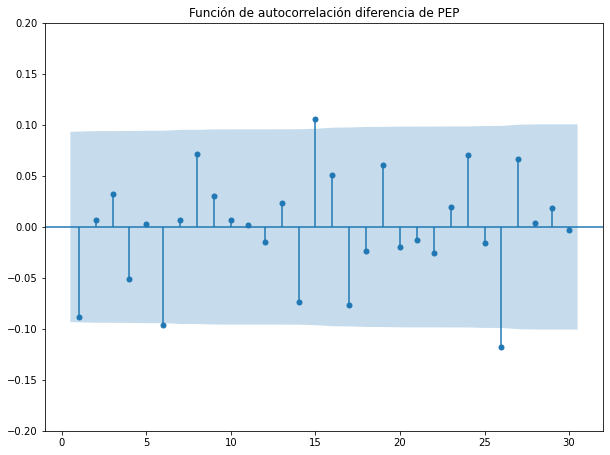

In [25]:
#grafica de autocorrelación ACF
plot_acf(pep_diff, zero=False, lags=30)
plt.title('Función de autocorrelación diferencia de PEP')
plt.ylim(-0.2,0.2)
plt.show()

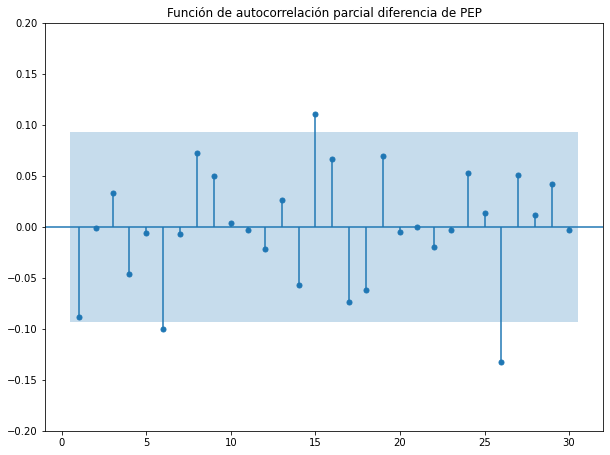

In [26]:
#grafica de autocorrelación parcial PACF
plot_pacf(pep_diff, zero=False, lags=30)
plt.title('Función de autocorrelación parcial diferencia de PEP')
plt.ylim(-0.2,0.2)
plt.show()

nota que el primer rezago de ACF y PACF es significativo, por lo que parece que la diferencia de las acciones de pep es en ARMA (1,1) 

In [44]:
# estimamos un ARMA (1,1)
modelo = ARIMA(pep_diff, order=(1, 0, 1))
resultado = modelo.fit()
resultado.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              adj_close   No. Observations:                  441
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -778.884
Date:                Sun, 13 Mar 2022   AIC                           1565.768
Time:                        21:09:25   BIC                           1582.124
Sample:                             0   HQIC                          1572.220
                                - 441                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0727      0.063      1.146      0.252      -0.052       0.197
ar.L1         -0.0771      0.492     -0.157      0.875      -1.041       0.887
ma.L1         -0.0109      0.499     -0.022      0.983      -0.988       0.967
sigma2         2.0026      0.110     18.211      0.000       1.787       2.218
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                24.17
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.37   Skew:                            -0.21
Prob(H) (two-sided):                  0.06   Kurtosis:                         4.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Note que la constante no es significativa, es decir, es cero. Pero los coeficientes de los rezagos si son significativos (distintos de cero) acuerdo con sus p-values

Aunque los ACF y PACF nos sugieren un ARMA(1,1), no son del todo precisos, asi que vamos a estimar varios modelos con 6 rezagos de AR, 6rezagos de MA y elegir uno de acuerdo con el BIC (criterio bayesiano de información)

In [45]:
ic = {}
for ar in range(7):
    for ma in range(7):
        print(f"AR: {ar}, MA: {ma}")
        modelo = ARIMA(pep_diff, order=(ar, 0, ma))
        resultado = modelo.fit()
        ic[(ar, ma)] = [resultado.aic, resultado.bic]

ic = pd.DataFrame(ic, index=["AIC", "BIC"]).T
ic.index = ic.index.set_names(["AR", "MA"])
ic

AR: 0, MA: 0
AR: 0, MA: 1
AR: 0, MA: 2
AR: 0, MA: 3
AR: 0, MA: 4
AR: 0, MA: 5
AR: 0, MA: 6
AR: 1, MA: 0
AR: 1, MA: 1
AR: 1, MA: 2
AR: 1, MA: 3
AR: 1, MA: 4
AR: 1, MA: 5
AR: 1, MA: 6
AR: 2, MA: 0
AR: 2, MA: 1
AR: 2, MA: 2


C:\Users\2400GV\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\2400GV\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR: 2, MA: 3
AR: 2, MA: 4
AR: 2, MA: 5
AR: 2, MA: 6
AR: 3, MA: 0
AR: 3, MA: 1
AR: 3, MA: 2
AR: 3, MA: 3


C:\Users\2400GV\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 3, MA: 4
AR: 3, MA: 5
AR: 3, MA: 6


C:\Users\2400GV\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 4, MA: 0
AR: 4, MA: 1
AR: 4, MA: 2
AR: 4, MA: 3


C:\Users\2400GV\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 4, MA: 4


C:\Users\2400GV\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 4, MA: 5


C:\Users\2400GV\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 4, MA: 6


C:\Users\2400GV\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 5, MA: 0
AR: 5, MA: 1
AR: 5, MA: 2
AR: 5, MA: 3


C:\Users\2400GV\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 5, MA: 4


C:\Users\2400GV\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 5, MA: 5


C:\Users\2400GV\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 5, MA: 6


C:\Users\2400GV\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 6, MA: 0
AR: 6, MA: 1
AR: 6, MA: 2
AR: 6, MA: 3
AR: 6, MA: 4


C:\Users\2400GV\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 6, MA: 5


C:\Users\2400GV\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 6, MA: 6


C:\Users\2400GV\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AIC          BIC
AR MA                          
0  0   1565.190771  1573.368861
   1   1563.801119  1576.068254
   2   1565.744486  1582.100665
   3   1567.429910  1587.875135
   4   1568.303058  1592.837327
   5   1570.146597  1598.769911
   6   1567.284148  1599.996507
1  0   1563.768881  1576.036016
   1   1565.768278  1582.124457
   2   1565.146944  1585.592168
   3   1566.512927  1591.047197
   4   1569.520748  1598.144062
   5   1571.359292  1604.071651
   6   1569.236556  1606.037960
2  0   1565.767825  1582.124004
   1   1567.768865  1588.214090
   2   1563.637115  1588.171385
   3   1568.507798  1597.131112
   4   1571.635730  1604.348089
   5   1567.836862  1604.638265
   6   1569.217815  1610.108264
3  0   1567.289109  1587.734334
   1   1566.536245  1591.070514
   2   1568.532678  1597.155992
   3   1567.332821  1600.045180
   4   1566.182438  1602.983842
   5   1567.568615  1608.459064
   6   1568.523414  1613.502908
4  0   1568.346662  1592.880932
   1   1569.624825  1598.248139
   2   1570.189912  1602.902271
   3   1566.704556  1603.505959
   4   1567.335028  1608.225477
   5   1569.297887  1614.277381
   6   1565.613081  1614.681619
5  0   1570.322244  1598.945558
   1   1571.565910  1604.278269
   2   1571.469857  1608.271260
   3   1568.133673  1609.024122
   4   1569.236842  1614.216335
   5   1568.773506  1617.842044
   6   1568.612645  1621.770229
6  0   1567.778987  1600.491346
   1   1569.757675  1606.559079
   2   1568.250067  1609.140516
   3   1569.201201  1614.180695
   4   1570.681286  1619.749824
   5   1566.932551  1620.090134
   6   1569.871461  1627.118089

los ordenamos de acuerdo al BIC que es el indicador que voy a utilizar

In [50]:
ic.sort_values('BIC', ascending = True)

AIC          BIC
AR MA                          
0  0   1565.190771  1573.368861
1  0   1563.768881  1576.036016
0  1   1563.801119  1576.068254
   2   1565.744486  1582.100665
2  0   1565.767825  1582.124004
1  1   1565.768278  1582.124457
   2   1565.146944  1585.592168
3  0   1567.289109  1587.734334
0  3   1567.429910  1587.875135
2  2   1563.637115  1588.171385
   1   1567.768865  1588.214090
1  3   1566.512927  1591.047197
3  1   1566.536245  1591.070514
0  4   1568.303058  1592.837327
4  0   1568.346662  1592.880932
2  3   1568.507798  1597.131112
3  2   1568.532678  1597.155992
1  4   1569.520748  1598.144062
4  1   1569.624825  1598.248139
0  5   1570.146597  1598.769911
5  0   1570.322244  1598.945558
0  6   1567.284148  1599.996507
3  3   1567.332821  1600.045180
6  0   1567.778987  1600.491346
4  2   1570.189912  1602.902271
3  4   1566.182438  1602.983842
4  3   1566.704556  1603.505959
1  5   1571.359292  1604.071651
5  1   1571.565910  1604.278269
2  4   1571.635730  1604.348089
   5   1567.836862  1604.638265
1  6   1569.236556  1606.037960
6  1   1569.757675  1606.559079
4  4   1567.335028  1608.225477
5  2   1571.469857  1608.271260
3  5   1567.568615  1608.459064
5  3   1568.133673  1609.024122
6  2   1568.250067  1609.140516
2  6   1569.217815  1610.108264
3  6   1568.523414  1613.502908
6  3   1569.201201  1614.180695
5  4   1569.236842  1614.216335
4  5   1569.297887  1614.277381
   6   1565.613081  1614.681619
5  5   1568.773506  1617.842044
6  4   1570.681286  1619.749824
   5   1566.932551  1620.090134
5  6   1568.612645  1621.770229
6  6   1569.871461  1627.118089

el BIC me sugiere un ARMA(0,0)

veamos que me sugiere el criterio de Akaike (AIC)

In [51]:
ic.sort_values('AIC', ascending = True)

,,AIC,BIC
AR,MA,,
2,2,1563.637115,1588.171385
1,0,1563.768881,1576.036016
0,1,1563.801119,1576.068254
1,2,1565.146944,1585.592168
0,0,1565.190771,1573.368861
4,6,1565.613081,1614.681619
0,2,1565.744486,1582.100665
2,0,1565.767825,1582.124004
1,1,1565.768278,1582.124457


criterio de AIC tambien me sugiere ARMA (2,2)

In [67]:
# estimamos un ARMA (2,2)
modelo = ARIMA(pep_diff, order=(2, 0, 2))
resultado = modelo.fit()
resultado.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              adj_close   No. Observations:                  441
Model:                 ARIMA(2, 0, 2)   Log Likelihood                -775.819
Date:                Sun, 13 Mar 2022   AIC                           1563.637
Time:                        21:16:43   BIC                           1588.171
Sample:                             0   HQIC                          1573.315
                                - 441                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0725      0.068      1.072      0.284      -0.060       0.205
ar.L1         -1.3453      0.036    -37.740      0.000      -1.415      -1.275
ar.L2         -0.9674      0.032    -30.133      0.000      -1.030      -0.904
ma.L1          1.3082      0.036     36.774      0.000       1.238       1.378
ma.L2          0.9582      0.034     27.830      0.000       0.891       1.026
sigma2         1.9724      0.110     17.923      0.000       1.757       2.188
===================================================================================
Ljung-Box (L1) (Q):                   0.62   Jarque-Bera (JB):                24.55
Prob(Q):                              0.43   Prob(JB):                         0.00
Heteroskedasticity (H):               1.41   Skew:                            -0.20
Prob(H) (two-sided):                  0.04   Kurtosis:                         4.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

En realidad, en este caso, como diferenciamos una vez la serie de tiempo estacionaria para hacerla estacionaria, nuestro modelo ARMA (2,2), es un ARIMA(2,1,2) de la serie original

In [68]:
# estimamos un ARIMA (2,2)
modelo2 = ARIMA(pep['adj_close'], order=(2, 1, 2))
resultado2 = modelo2.fit()
resultado2.summary()

C:\Users\2400GV\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\2400GV\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\2400GV\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              adj_close   No. Observations:                  442
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -776.421
Date:                Sun, 13 Mar 2022   AIC                           1562.842
Time:                        21:16:45   BIC                           1583.288
Sample:                             0   HQIC                          1570.907
                                - 442                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3452      0.035    -38.022      0.000      -1.415      -1.276
ar.L2         -0.9676      0.032    -30.385      0.000      -1.030      -0.905
ma.L1          1.3084      0.035     37.210      0.000       1.239       1.377
ma.L2          0.9587      0.034     28.221      0.000       0.892       1.025
sigma2         1.9778      0.110     17.905      0.000       1.761       2.194
===================================================================================
Ljung-Box (L1) (Q):                   0.63   Jarque-Bera (JB):                24.56
Prob(Q):                              0.43   Prob(JB):                         0.00
Heteroskedasticity (H):               1.40   Skew:                            -0.20
Prob(H) (two-sided):                  0.04   Kurtosis:                         4.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [69]:
# vamos a estimar la serie con el modelo ARIMA
pep['pronostico'] = resultado2.predict()
pep['pronostico'][0] = pep['adj_close'][0]

C:\Users\2400GV\AppData\Local\Temp/ipykernel_6572/3699779431.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pep['pronostico'][0] = pep['adj_close'][0]


graficamos la y_estimada con la y_original

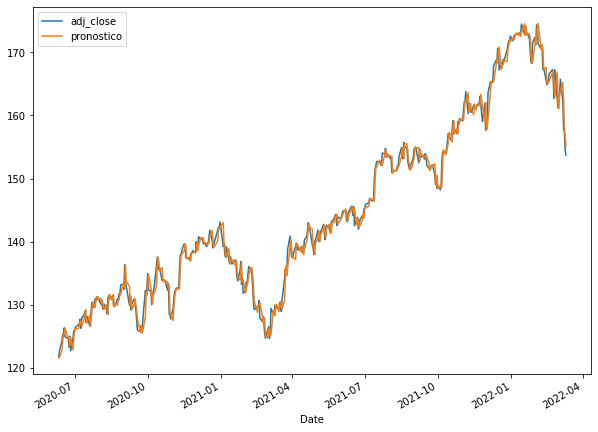

In [70]:
pep[['adj_close', 'pronostico']].plot()
plt.show()

In [71]:
#calculamos cuantas observaciones tenemos para hacer nuestra predicción
len(pep)

442

la función len nos arrojo que tenemos 442 observaciones,  quiere decir que el lunes sería la observación 443, el martes la 444, y el miércoles la 445

In [72]:
## vamos a pronosticar esos días
resultado2.predict(443, 445)

C:\Users\2400GV\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


443    153.183009
444    153.871506
445    153.353423
Name: predicted_mean, dtype: float64

mi pronostico para el lunes 14 de marzo es que la acción de walmart tenga un precio de cierre (ajustado) de 153.183009

El viernes cerro en 153.729996	